<h1>Feather Tutorial</h1>

The required input images should be generated using feather_tutorial_create_initial_images.ipynb

In [1]:
from toolviper.dask.client import local_client
log_params = {'log_level':'DEBUG'}
worker_log_params = {'log_level':'DEBUG'}
viper_client = local_client(cores=1, memory_limit="8.0GiB",log_params=log_params,worker_log_params=worker_log_params)
#viper_client = local_client(serial_execution=True)
# viper_client

from astroviper.imaging import feather
feather(outim={"name": "feathered_image.img.zarr", "format": "zarr", "overwrite": True}, highres= 'int.zarr', lowres= 'sd.zarr', sdfactor=1)

[2025-08-14 17:39:04,617]     INFO    viperlog:  Module path: /home/dmehring/miniforge3/envs/astroviper/lib/python3.12/site-packages/toolviper 
[2025-08-14 17:39:04,626]  WARNING    viperlog:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 


/home/dmehring/miniforge3/envs/astroviper/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46001 instead
  warnings.warn(


[2025-08-14 17:39:07,132]    DEBUG    worker_0:  Logger created on worker Worker-dce887d9-bcdf-4427-be86-c0e8375b861d,*,tcp://127.0.0.1:36161
[2025-08-14 17:39:07,135]     INFO    viperlog:  Client <MenrvaClient: 'tcp://127.0.0.1:36283' processes=1 threads=1, memory=8.00 GiB> 
[2025-08-14 17:39:13,056]  WARNING  graphviper:  Because overwrite=True, removing existing path feathered_image.img.zarr 
[2025-08-14 17:39:19,277]    DEBUG    worker_0:  1. Before compressor feathered_image.img.zarr/SKY/0.0.0.0.0
[2025-08-14 17:39:19,327]    DEBUG    worker_0:  2. Before makedir
[2025-08-14 17:39:19,327]    DEBUG    worker_0:  3. Before write the len is: 14341348
[2025-08-14 17:39:19,328]    DEBUG    worker_0:  4. Using new writer: 14341348
[2025-08-14 17:39:19,340]    DEBUG    worker_0:  4. Write completed
[2025-08-14 17:39:21,563]    DEBUG    worker_0:  1. Before compressor feathered_image.img.zarr/SKY/0.2.0.0.0
[2025-08-14 17:39:21,605]    DEBUG    worker_0:  2. Before makedir
[2025-08-14 17:

INFO:graphviper:Time to compute() feather 12.94547438621521s


(1, 16, 1, 1024, 1024)
cellsize of feathered image [15. 15.] arcsec


<xarray.Dataset> Size: 84MB
Dimensions:          (time: 1, frequency: 16, polarization: 1, beam_param: 3,
                      l: 1024, m: 1024)
Coordinates:
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
    declination      (l, m) float64 8MB -0.2371 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 8MB 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 8B 0.0
    velocity         (frequency) float64 128B 1.1e+07 9.626e+06 ... -9.626e+06
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
Data variables:
    BEAM             (time, frequency, polarization, beam_param) float32 192B dask.array<chunksize=(1, 16, 1, 3), meta=np.ndarray>
    SKY              (time, frequency, polarization, l, m) float32 67MB dask.array<chunksize=(1, 4, 1, 1024, 1024), meta=np.ndarray>
Attributes:
    data_groups:  {'base': {}}
    direction:    {'latpole': {'attrs': {'type': 'quantity', 'units': ['rad']...

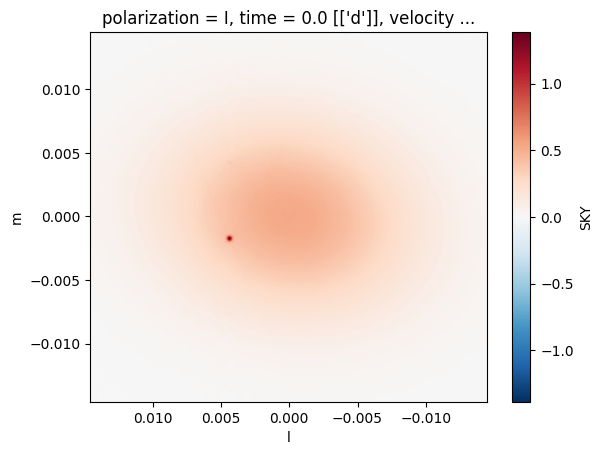

In [2]:
import numpy as np
from xradio.image import load_image, read_image
feather_xds = read_image("feathered_image.img.zarr")
print(feather_xds.SKY.shape)
center = feather_xds.SKY.shape[3]//2
cell = np.array([feather_xds.l[0] - feather_xds.l[1], feather_xds.m[1] - feather_xds.m[0]]) * 180*3600/np.pi
print(f"cellsize of feathered image {cell} arcsec")

import numpy as np
# np.nanmax(np.abs(feather_xds.SKY.values))
mslice = slice(center-200, center+200)
# lslice = slice(center-200, center+200, -1)
# feather_xds.SKY.isel(polarization=0,frequency=0,l=mslice, m=mslice).plot()
# feather_xds.SKY.isel(
#    time=0, frequency=0, polarization=0,
#    l=mslice, m=mslice).isel(l=slice(None, None, 1)).plot.pcolormesh(x="l", y="m")

def plot_correct_orientation(xda):
    xda.plot.pcolormesh(x="l", y="m").axes.invert_xaxis()

plot_correct_orientation(
    feather_xds.SKY.isel(
        time=0, frequency=0, polarization=0, l=mslice, m=mslice
    )
)

feather_xds

# COMPARISON WITH TRUTH

The input images were created from a simulation. A model image of an extended gaussian
and a point source was created. The model was convolved with a large gaussian beam representing
the single dish beam. That image was used as the single dish input image to feather. The
original model image was used to simulate an interferometer response using the CASA 6 simulator
module. That MS was then used to make the dirty simulated image that was used as the interferometeinput to feather. Instrumental noise was not simulated. The noise in the feather image reflects
the software processesing.

So, the resulting image produced by feather can be directly compaired with "truth" in the form
of the model from which it was ultimately generated. To allow direct comparison, the model
was convolved with the same beam that is present in the feather image.

In [7]:
# model is l x m x chan = 1024 x 1024 x 16 so the created feather image
# should have the same shape or else there will be difficulty doing some
# comparisions
from toolviper.utils.data import download, update
update()
download("feather_model_convolved")

[2025-08-14 17:44:12,891]  WARNING  graphviper:  File exists: /home/dmehring/miniforge3/envs/astroviper/lib/python3.12/site-packages/toolviper/utils/data/.cloudflare 


[2025-08-14 17:44:12,894]     INFO  graphviper:  Updating file metadata information ...  


INFO:graphviper:Updating file metadata information ... 


Output()

[2025-08-14 17:44:13,557]     INFO  graphviper:  Downloading from [cloudflare] .... 


INFO:graphviper:Downloading from [cloudflare] ....


 Download List            
 ───────────────────────── 
  feather_model_convolved

Output()

[2025-08-14 17:44:28,273]     INFO  graphviper:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


INFO:graphviper:J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately


Successful readonly open of default-locked table feather_model_convolved.im: 1 columns, 1 rows
[2025-08-14 17:44:28,289]     INFO  graphviper:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


INFO:graphviper:J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately


cellsize of model image [15. 15.] arcsec


<xarray.Dataset> Size: 84MB
Dimensions:          (time: 1, frequency: 16, polarization: 1, l: 1024,
                      m: 1024, beam_param: 3)
Coordinates:
  * time             (time) float64 8B 0.0
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 128B 1.1e+07 9.626e+06 ... -9.626e+06
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.03727 0.03727 0.03727 ... 6.246 6.246
    declination      (l, m) float64 8MB -0.03724 -0.03717 ... 0.0371 0.03717
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 67MB dask.array<chunksize=(1, 16, 1, 1024, 1024), meta=np.ndarray>
    BEAM             (time, frequency, polarization, beam_param) float64 384B dask.array<chunksize=(1, 16, 1, 3), meta=np.ndarray>
Attributes:
    direction:  {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord',...

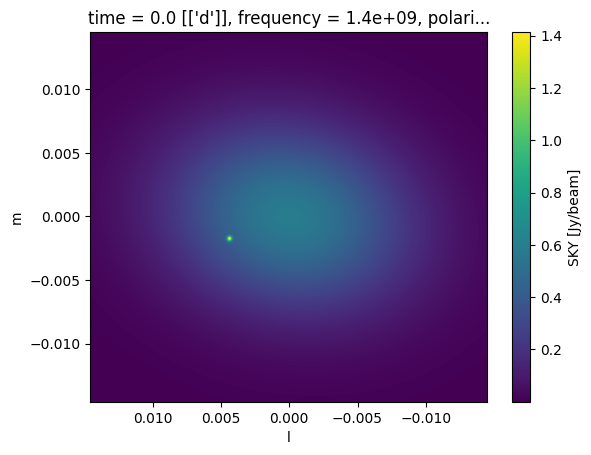

In [8]:
xds_model=read_image("feather_model_convolved.im")
plot_correct_orientation(
    xds_model.SKY.isel(
        time=0, frequency=0, polarization=0, l=mslice, m=mslice
    )
)
cell = np.array([xds_model.l[0] - xds_model.l[1], xds_model.m[1] - xds_model.m[0]]) * 180*3600/np.pi
print(f"cellsize of model image {cell} arcsec")
if feather_xds.SKY.shape != xds_model.SKY.shape:
    raise ValueError(
        "feathered image and model image have different dimensions, cannot do direct comparisons "
        f"recreate feather input images to have shape {xds_model.SKY.shape}"
    )
xds_model

COMPARE BEAMs
(1, 16, 1, 3)
max beam FWHM major axis diff 3.832733109620373e-09
max beam FWHM minor axis diff 2.2563032060665504e-09
max beam pa diff 9.562206235158577e-10
all planes in feathered image equal? True
all planes in model image equal? True
feather plane sum 21276.088
model plane sum 21275.71
relative difference in sums 1.7762184e-05
feather max pixel value location is [0, 0, 452, 488]
model max pixel value location is [0, 0, 452, 488]
are they the same position? True
feather max value 1.3862089
model max value 1.4138035
relative diff -0.019517958
feather center max pixel value location is [0, 0, 19, 19]
model center max pixel value location is [0, 0, 20, 20]
are they the same position? False
what is the pixel difference between them? [ 0  0 -1 -1]
feather center max value 0.5338305830955505
model center max value 0.5857419371604919
This difference suggests that perhpas the actual beam of the feather image is about 4.7% wider than the interferometer beam


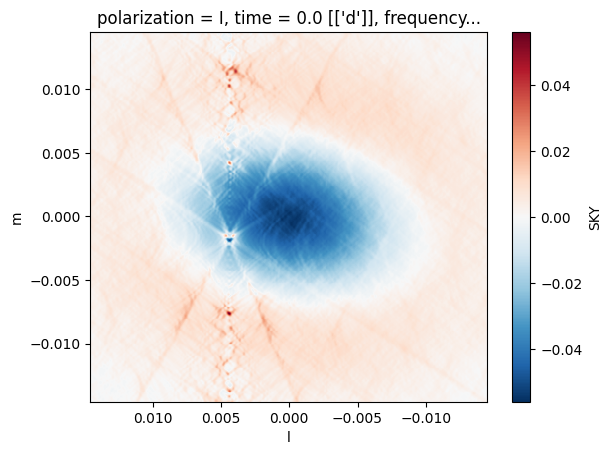

In [9]:
import xarray as xr; import dask.array as da
# align coords to avoid issues with machine precision level differences
feather_xds_aligned, model_xds_aligned = xr.align(feather_xds, xds_model, join="override")
beam_diff = feather_xds_aligned.BEAM - model_xds_aligned.BEAM
print("COMPARE BEAMs")
print(beam_diff.shape)
for dim, name in zip(
    ("major", "minor", "pa"), ("FWHM major axis", "FWHM minor axis", "pa")
):
    print(
        f"max beam {name} diff",
        da.absolute(beam_diff.sel(beam_param=dim)).max().compute().item()
    )

# in each cube, all freq planes have identical values, so we only need one plane from
# each image to do comparisons. Identical planes were just stacked so there
# could be multiple frequency channels.
for name, cube in zip(
    ("feathered image", "model image"), (feather_xds.SKY, xds_model.SKY)
):
    zero_cube = cube - cube.isel(frequency=0)
    print(
        f"all planes in {name} equal?",
        (zero_cube == 0).all().compute().values
    )

# get a plane from each for further comparison
feather_plane = feather_xds.SKY.isel(frequency=0)
model_plane = xds_model.SKY.isel(frequency=0)

# compare the sums of pixel values which is just the flux desnity 
# times a beam dependent factor that is the same for both images
# because the beams are the same

feather_sum = feather_plane.sum()
model_sum = model_plane.sum()
print("feather plane sum", feather_sum.compute().values)
print("model plane sum", model_sum.compute().values)
# the relative difference in sums is on the order of machine precision, so it's
# about as good as can be hoped for. The feather image contains all the flux of
# the model
print("relative difference in sums", (feather_sum/model_sum - 1).compute().values)

# look at the max pos for each image, this is the point source
feather_maxpos = [
    int(x) for x in np.unravel_index(
        np.argmax(feather_plane.compute().values), feather_plane.shape
    )
]
model_maxpos = [
    int(x) for x in np.unravel_index(
        np.argmax(model_plane.compute().values), model_plane.shape
    )    
]
print("feather max pixel value location is", feather_maxpos)
print("model max pixel value location is", model_maxpos)
print("are they the same position?", feather_maxpos == model_maxpos)

# what is the value
feather_max = feather_plane.max().compute().values
model_max = model_plane.max().compute().values
print("feather max value", feather_max)
print("model max value", model_max)
print("relative diff", feather_max/model_max - 1)

# find the max of the extended gaussian
pslice = slice(center-20, center+20)
feather_center_region = feather_plane.isel(l=pslice, m=pslice)
model_center_region = model_plane.isel(l=pslice, m=pslice)

feather_center_maxpos = [
    int(x) for x in np.unravel_index(
        np.argmax(feather_center_region.compute().values), feather_center_region.shape
    )
]
model_center_maxpos = [
    int(x) for x in np.unravel_index(
        np.argmax(model_center_region.compute().values), model_center_region.shape
    )    
]
print("feather center max pixel value location is", feather_center_maxpos)
print("model center max pixel value location is", model_center_maxpos)
print("are they the same position?", feather_center_maxpos == model_center_maxpos)
# this originally showed an offset of (1,1) pixel
print(
    "what is the pixel difference between them?",
    np.array(feather_center_maxpos) - np.array(model_center_maxpos)
)
feather_guass_peak = feather_center_region[tuple(feather_center_maxpos)].compute().item()
model_gauss_peak = model_center_region[tuple(feather_center_maxpos)].compute().item()
print("feather center max value", feather_guass_peak)
print("model center max value", model_gauss_peak)

# if the max of the model is greater than than the feather image, something
# to consider is that the effective resolution of the feather image may be
# less than the beam since the interferometer beam is really the maximum the
# resolution can be. The proper way to get the resolution of the feather image
# would be to feather the single dish beam with the interferometer dirty beam
# and fit a gaussian to the resulting feathered beam.

rel_diff = feather_guass_peak / model_gauss_peak

if rel_diff < 1:
    print(
        "This difference suggests that perhpas the actual beam of the feather "
        f"image is about{(np.sqrt(1/rel_diff) - 1)*100: .1f}% wider than the "
        "interferometer beam"
    )

# plot the difference image
plot_correct_orientation(
    (feather_xds_aligned.SKY - model_xds_aligned.SKY).isel(
        time=0, frequency=0, polarization=0, l=mslice, m=mslice
    )
)

In [ ]:
# TODO fit gaussians and compare

# MODEL GENERATION SCRIPT
For completeness, this is the script that was used to generate the images used here.
No garauntees that it still runs since it was created probably before the pandemic.
But, it can be inspected to see exactly how the model, the uv dataset created from it,
and the dirty interferometer image were created.

In [ ]:
from casatools import (
    componentlist, ctsys, image, measures, simulator
)
import os, shutil
from casatasks import feather2, tclean
from casatasks.private import simutil
import glob
from dask import array as da
import numpy as np

def __direction_string(ra, dec, frame):
    """helper function for often needed string"""
    return ' '.join([frame, ra, dec])

def __makeMSFrame(antenna_file, spwname, freq, radir, decdir, dirframe):
    """
    Construct an empty Measurement Set that has the desired
    observation setup.
    """
    # Open the simulator
    sm.open(ms=sim_ms)
    # Read/create an antenna configuration.
    # Canned antenna config text files are located at
    # /home/casa/data/trunk/alma/simmos/*cfg
    # antennalist = os.path.join(ctsys.resolve("alma/simmos"), "vla.d.cfg")
    # Fictitious telescopes can be simulated by specifying x, y, z, d,
    # an, telname, antpos.
    # x,y,z are locations in meters in ITRF (Earth centered)
    # coordinates.
    # d, an are lists of antenna diameter and name.
    # telname and obspos are the name and coordinates of the
    # observatory.
    (x, y, z, d, an, an2, telname, obspos) = (
        simutil.simutil().readantenna(antenna_file)
    )
    # Set the antenna configuration
    sm.setconfig(
        telescopename=telname, x=x, y=y, z=z, dishdiameter=d,
        mount=['alt-az'], antname=an, coordsystem='global',
        referencelocation=me.observatory(telname)
    )
    # Set the polarization mode (this goes to the FEED subtable)
    sm.setfeed(mode='perfect R L', pol=[''])
    # Set the spectral window and polarization (one
    # data-description-id).
    # Call multiple times with different names for multiple SPWs or
    # pol setups.
    sm.setspwindow(
        spwname=spwname, freq=freq, deltafreq='1MHz',
        freqresolution='2MHz', nchannels=5, stokes='RR LL'

    )
    # Setup source/field information (i.e. where the observation phase
    # center is) Call multiple times for different pointings or source
    # locations.
    sm.setfield(
        sourcename="fake", sourcedirection=me.direction(
            rf=dirframe, v0=radir, v1=decdir
        )
    )
    # Set shadow/elevation limits (if you care). These set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='1deg')
    # Leave autocorrelations out of the MS.
    sm.setauto(autocorrwt=0.0)
    # Set the integration time, and the convention to use for timerange
    # specification
    # Note : It is convenient to pick the hourangle mode as all times
    #   specified in sm.observe() will be relative to when the source
    #   transits.
    sm.settimes(
        integrationtime='30s', usehourangle=True,
        referencetime=me.epoch('UTC', '2019/10/4/00:00:00')
    )
    # Construct MS metadata and UVW values for one scan and ddid
    # Call multiple times for multiple scans.
    # Call this with different sourcenames (fields) and spw/pol
    # settings as defined above.
    # Timesteps will be defined in intervals of 'integrationtime',
    # between starttime and stoptime.
    sm.observe(
        sourcename="fake", spwname=spwname, starttime='-6.0h',
        stoptime='+6.0h'
    )
    # Close the simulator
    sm.close()
    # Unflag everything (unless you care about elevation/shadow flags)
    # flagdata(vis=orig_ms, mode='unflag')

def __predictSimFromComplist():
    sm.openfromms(sim_ms)
    # Predict from a component list
    sm.predict(complist=model_cl, incremental=False)
    sm.close()

def __create_input_ms():
    """create the input MS"""
    antenna_file = os.path.join(ctsys.resolve('alma/simmos'), 'vla.d.cfg')
    spwname = 'LBand'
    freq = '1.415GHz'
    fra = '0h0m0'
    fdec = '0d0m0s'
    fframe = 'J2000'
    radir = fra
    decdir = fdec
    dirframe = fframe
    __makeMSFrame(antenna_file, spwname, freq, fra, fdec, fframe)
    # Predict Visibilities
    __predictSimFromComplist()

 
# create model image
ia = image()
cl = componentlist()
sm = simulator()
me = measures()

print('create model image')

temp_im = 'template.im'
model_shape = [4096, 4096, 1, 5]
ia.fromshape(temp_im, model_shape, overwrite=True)
csys = ia.coordsys()
# VLA 1.5 GHz D array synthesized beam = 46"
csys.setunits(['arcsec', 'arcsec', '', 'Hz'])
csys.setincrement([-15, 15, 1,1e6])
ia.setcoordsys(csys.torecord())
ia.done()

# create model componentlist, one extended component + one point source
# Largest angular scale VLA D array 1.5 GHz is 970", so make diameter of Gaussian
# much larger
cl.addcomponent(
    flux=[1_000], fluxunit='Jy', polarization='Stokes',
    dir=['0:0:0', '+00.0.0'], shape='gaussian',
    majoraxis='50arcmin', minoraxis='40arcmin', positionangle='75deg',
    freq=[], spectrumtype='constant', label='extended componenet'
)

# point source 
cl.addcomponent(
    flux=[1], fluxunit='Jy', polarization='Stokes',
    dir=['0:1:0', '-00.6.0'], shape='point',
    freq=[], spectrumtype='constant', label='point componenet'
)
model_cl = 'model.cl'
if os.path.exists(model_cl):
    shutil.rmtree(model_cl)
cl.rename(model_cl)
cl.done()

model_im = 'model.im'
ia.fromcomplist(model_im, shape=model_shape, cl=model_cl, csys=csys.torecord(), overwrite=True)

print('create single dish image')

# make the single dish image, the image has resolution that would correspond to an 
# antenna about twice a VLA dish diameter
sd_im = 'single_dish.im'
ia.convolve2d(
    outfile=sd_im, axes=[0, 1], type='gaussian', major='14arcmin',
    minor='14arcmin', pa='0deg', overwrite=True, targetres=True
)
ia.done()

print('create VLA MS')

sim_ms = 'vla_sim.ms'
__create_input_ms()

vla_im = 'vla_im'
for path in glob.glob('vla_im.*'):
    shutil.rmtree(path)

print('make tclean VLA image')

tclean(
    vis=sim_ms, imagename=vla_im, datacolumn='data', imsize=4096,
    cell='15arcsec', gridder='wproject', niter=20, pblimit=-1,
    specmode='cube', nchan=5
)
# the sim tool doesn't appear to honor frequencies provided to it
# so we have to munge the image header
print('munge csys of tclean image')
ia.open(vla_im + '.image')
csys = ia.coordsys()
rval = csys.referencevalue()['numeric']
rval[3] = 1.415e+09     
csys.setreferencevalue(rval)
rpix = csys.referencepixel()['numeric']
rpix[3] = 2
csys.setreferencepixel(rpix)
inc = csys.increment()['numeric']
inc[3] = 1e6
csys.setincrement(inc)
print('increment', csys.increment())
ia.setcoordsys(csys.torecord())
csys.done()
ia.done()
"""
print('run feather2')
feather_im = 'feather.im'
if os.path.exists(feather_im):
    shutil.rmtree(feather_im)

hr_im = vla_im + '.image'
#feather2(feather_im, highres=hr_im, lowres=sd_im)
"""
"""
print('create fft of VLA tcleaned image')
final = 'feather.im'
if os.path.exists(final):
    shutil.rmtree(final)
ia.open(vla_im + '.image')
vla_beam_area = ia.beamarea(0, 0)['arcsec2']
vla_pix = da.from_array(ia.getchunk(), chunks=[1024, 1024, 1, 1])
ia.subimage(final)
ia.done()
vla_pix_fft = da.fft.fft2(vla_pix, axes=[0, 1])

print('create fft of single dish image')
ia.open(sd_im)
sd_pix = da.from_array(ia.getchunk(), chunks=[1024, 1024, 1, 1])
sd_beam_area = ia.beamarea()['arcsec2']
ia.done()
sd_pix_fft = da.fft.fft2(sd_pix, axes=[0, 1])

print('add ffts')

combined_fft = vla_beam_area/sd_beam_area*sd_pix_fft + vla_pix_fft

print('ifft combined back to image plane')

combined_ifft = da.fft.ifft2(combined_fft, axes=[0, 1])

print('type of combined_ifft', combined_ifft.compute().dtype)

ia.open(final)
# ia.putchunk(np.absolute(combined_ifft.compute()))
ia.putchunk(np.real(combined_ifft.compute()))
ia.done()
"""


"""
sd_fft = 'sd_fft_complex.im'
if os.path.exists(sd_fft):
    shutil.rmtree(sd_fft)
ia.open(sd_im)
print('fft single dish image')
ia.fft(complex=sd_fft)
ia.done()
print()
vla_fft = 'vla_fft_complex.im'
if os.path.exists(vla_fft):
    shutil.rmtree(vla_fft)
ia.open(vla_im + '.image')
print('fft clean image')
ia.fft(complex=vla_fft)
ia.done()

print('add fft\'ed images')
fft_combine = 'combined_fft.im'
ia.fromshape(fft_combine)
ia.calc(vla_fft + '+' + sd_fft)
ia.done()
"""
